In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [114]:
class Value:
    def __init__(self,data , _children =() , _op = '', label = ''):
        self.data = data
        self._op = _op
        self.grad = 0.0
        self._backward = lambda : None
        self.label = label
        self._prev = set(_children)
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data + other.data , (self, other) , '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data ,( self , other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self , other):
        return self * other
    def __truediv__(self, other): # self / other
        return self * other**-1
    def exp(self):
        x = self.data
        out = Value(math.exp(x) , (self , ) ,'exp')
        def _backward():
            self.grad +=  out.data * out.grad
        out._backward = _backward
        return out
    def __neg__(self):
        return self * -1
    def __sub__(self,other):
        return self + (-other)
    def __pow__(self ,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data**other.data , (self ,other) , '^')
        def _backward():
            self.grad += (other.data) * (self.data ** (other.data - 1)) * out.grad
        out._backward = _backward
        return out
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t,(self, ),'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        
        return out
    def backward(self):
        self.grad = 1.0
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()
        

In [5]:
from graphviz import Digraph
def trace(root):
    nodes ,edges = set(),set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
    build(root)
    return nodes,edges
def draw_dot(root):
    dot = Digraph(format='svg',graph_attr={'rankdir' : 'LR'})
    nodes,edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid,label = "{%s | data %.4f | grad %.4f}" %(n.label , n.data,n.grad), shape = 'record')
        if n._op:
            dot.node(name = uid + n._op ,label = n._op)
            dot.edge(uid + n._op , uid)
    for n1,n2 in edges:
        dot.edge(str(id(n1)),str(id(n2)) + n2._op)
    return dot

In [102]:
#input x1_x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0 ,label = 'x2')
w1 = Value(-3.0 ,label = 'w1')
w2 = Value(1.0,label='w2')
b = Value(6.88137358 , label = 'b')
x1w1 = x1*w1 ;x1w1.label = 'x1w1'
x2w2 = x2*w2 ;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
o = n.tanh() ; o.label = 'o'
o.backward()

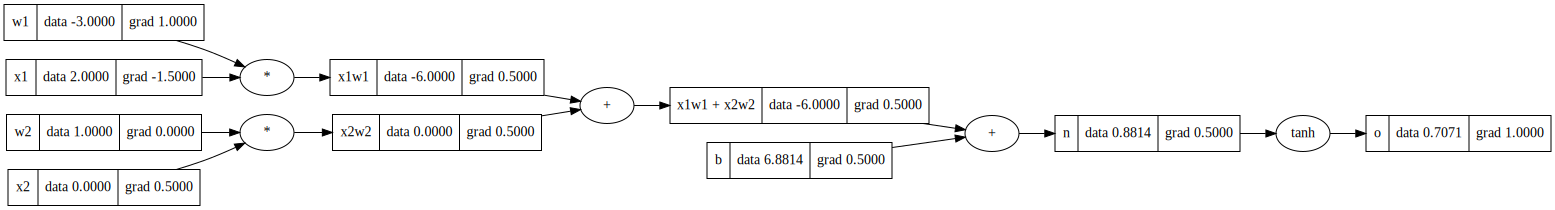

In [103]:
draw_dot(o)

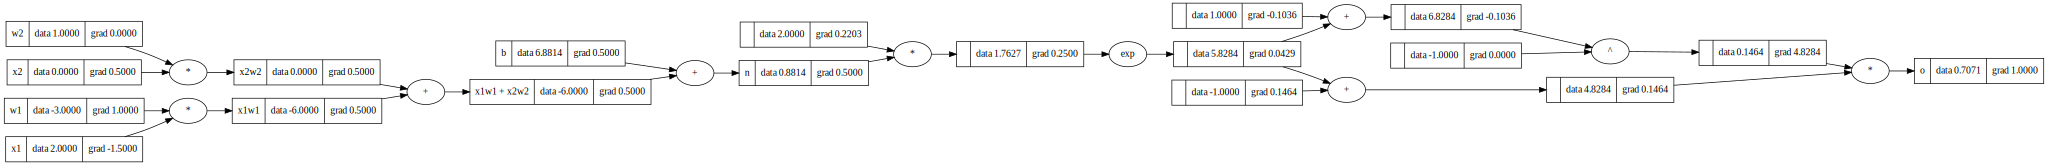

In [101]:
#input x1_x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0 ,label = 'x2')
w1 = Value(-3.0 ,label = 'w1')
w2 = Value(1.0,label='w2')
b = Value(6.88137358 , label = 'b')
x1w1 = x1*w1 ;x1w1.label = 'x1w1'
x2w2 = x2*w2 ;x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2 ;x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b ; n.label = 'n'
#---------------
e  = (2*n).exp()
o = (e - 1) / (e + 1)
#--------------
o.label = 'o'
o.backward()
draw_dot(o)


In [126]:
import torch
import random
class Neuron:
    def __init__(self , nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin) ]
        self.b = Value(random.uniform(-1,1))
    def __call__(self,x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)),Value(0)) + self.b
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]

class Layer:
  
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  
  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs
  
  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [128]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.4208799977494849)

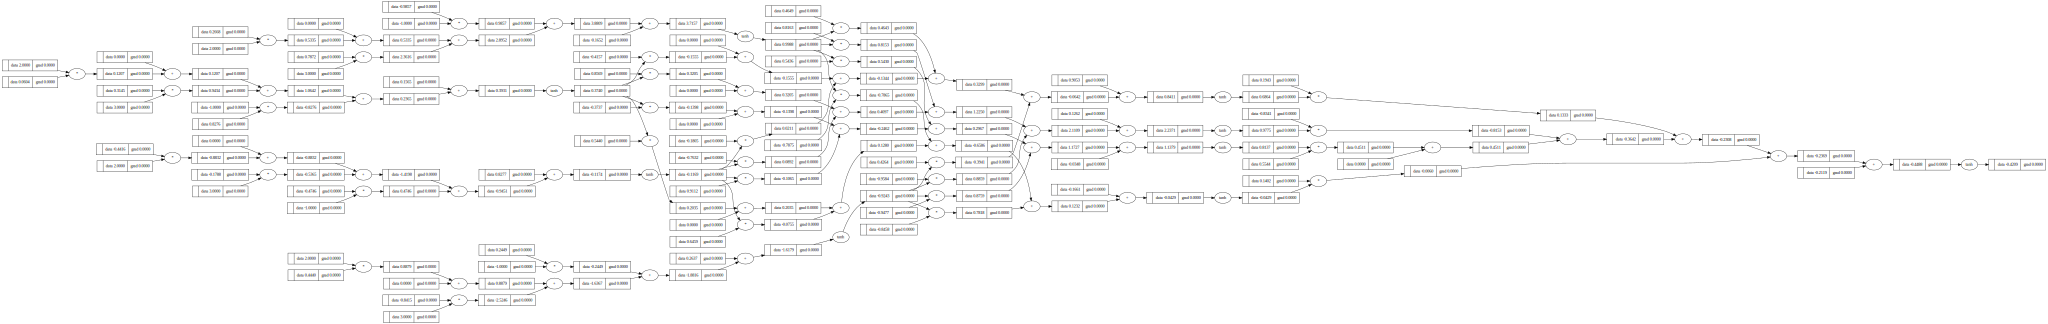

In [129]:
draw_dot(n(x))